# ALUMNO: Ezequiel Scordamaglia

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding


### Datos
Utilizaremos como dataset fragmentos de libros de Borges. (Utilizando datasets tomados de este repositorio: https://github.com/karen-pal/borges/tree/master)

In [2]:
with open('./data/borges_full_texts.pkl', 'rb') as f:
   borges = pickle.load(f)

In [3]:
with open('./data/cortazar_full_texts.pkl', 'rb') as f:
   cortazar = pickle.load(f)

In [4]:
with open('./data/bioy_casares_full_texts.pkl', 'rb') as f:
   bioy_casares = pickle.load(f)

In [5]:
borges.head()

,link,text_metadata,text
0,https://ciudadseva.com/texto/abel-y-cain-borges/,"{'title': 'Abel y Caín', 'metadata': '[Minicue...",Abel y Caín se encontraron después de la muert...
1,https://ciudadseva.com/texto/adrogue/,"{'title': 'Adrogué', 'metadata': '[Minicuento ...","Era muy lindo, un pueblo laberíntico. A veces,..."
2,https://ciudadseva.com/texto/alguien-sonara/,"{'title': 'Alguien soñará', 'metadata': '[Mini...",¿Qué soñará el indescifrable futuro? Soñará qu...
3,https://ciudadseva.com/texto/andres-armoa/,"{'title': 'Andrés Armoa', 'metadata': '[Minicu...",Los años le han dejado unas palabras en guaran...
4,https://ciudadseva.com/texto/argumentum-ornith...,"{'title': 'Argumentum ornithologicum', 'metada...",Cierro los ojos y veo una bandada de pájaros. ...


In [6]:
# Unificar los tres corpus, quedandome solo con la columna text
df = pd.concat([borges, cortazar, bioy_casares], axis=0, ignore_index=True)[['text']]
df

,text
0,Abel y Caín se encontraron después de la muert...
1,"Era muy lindo, un pueblo laberíntico. A veces,..."
2,¿Qué soñará el indescifrable futuro? Soñará qu...
3,Los años le han dejado unas palabras en guaran...
4,Cierro los ojos y veo una bandada de pájaros. ...
...,...
125,-Fueran cuales fueran los resultados -declaró ...
126,"Cuando entró en el edificio, buscó las escaler..."
127,"Conozco a una muchacha generosa y valiente, si..."
128,Algunos al héroe lo llaman holgazán. Él se res...


In [7]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 130


In [8]:
# Desordenar registros
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
df

,text
0,La obra visible que ha dejado este novelista e...
1,Anterior al tiempo o fuera del tiempo (ambas l...
2,"La noche del catorce de marzo de 1939, en un d..."
3,"A mí, tan luego, hablarme del finado Francisco..."
4,Al atardecer Florencio bajó con la nena hasta ...
...,...
125,Un cóndor cae como un rayo sobre un cronopio q...
126,En aquel entonces era difícil saberlo. Uno va ...
127,"Recabarren, tendido, entreabrió los ojos y vio..."
128,No entiendo por qué no me dejan pasar la noche...


### 1 - Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [10]:

# largo de la secuencia, incluye seq input + word output
train_len = 4
separator_word = 'sep0000'

Debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [11]:
# Vistazo a las primeras filas
df.loc[:15]

,text
0,La obra visible que ha dejado este novelista e...
1,Anterior al tiempo o fuera del tiempo (ambas l...
2,"La noche del catorce de marzo de 1939, en un d..."
3,"A mí, tan luego, hablarme del finado Francisco..."
4,Al atardecer Florencio bajó con la nena hasta ...
5,Bajo el notorio influjo de Chesterton (discurr...
6,"Cuidamos las mancuspias hasta bastante tarde, ..."
7,Con lo que pasa es nosotros exaltante. Rápidam...
8,Un cronopio pequeñito buscaba la llave de la p...
9,Tantos años huyendo y esperando y ahora el ene...


In [12]:
# Concatenamos todos los rows en un solo valor
# corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus = df['text'].str.cat(sep=' ' + separator_word + ' ')
# corpus

In [13]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:50]

['la',
 'obra',
 'visible',
 'que',
 'ha',
 'dejado',
 'este',
 'novelista',
 'es',
 'de',
 'fácil',
 'y',
 'breve',
 'enumeración',
 'son',
 'por',
 'lo',
 'tanto',
 'imperdonables',
 'las',
 'omisiones',
 'y',
 'adiciones',
 'perpetradas',
 'por',
 'madame',
 'henri',
 'bachelier',
 'en',
 'un',
 'catálogo',
 'falaz',
 'que',
 'cierto',
 'diario',
 'cuya',
 'tendencia',
 'protestante',
 'no',
 'es',
 'un',
 'secreto',
 'ha',
 'tenido',
 'la',
 'desconsideración',
 'de',
 'inferir',
 'a',
 'sus']

In [14]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 240539


In [15]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  if separator_word not in seq:
    text_sequences.append(seq)

In [16]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['la', 'obra', 'visible', 'que'],
 ['obra', 'visible', 'que', 'ha'],
 ['visible', 'que', 'ha', 'dejado'],
 ['que', 'ha', 'dejado', 'este'],
 ['ha', 'dejado', 'este', 'novelista'],
 ['dejado', 'este', 'novelista', 'es'],
 ['este', 'novelista', 'es', 'de'],
 ['novelista', 'es', 'de', 'fácil'],
 ['es', 'de', 'fácil', 'y'],
 ['de', 'fácil', 'y', 'breve'],
 ['fácil', 'y', 'breve', 'enumeración'],
 ['y', 'breve', 'enumeración', 'son'],
 ['breve', 'enumeración', 'son', 'por'],
 ['enumeración', 'son', 'por', 'lo'],
 ['son', 'por', 'lo', 'tanto'],
 ['por', 'lo', 'tanto', 'imperdonables'],
 ['lo', 'tanto', 'imperdonables', 'las'],
 ['tanto', 'imperdonables', 'las', 'omisiones'],
 ['imperdonables', 'las', 'omisiones', 'y'],
 ['las', 'omisiones', 'y', 'adiciones']]

In [17]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[2, 339, 1441, 3],
 [339, 1441, 3, 64],
 [1441, 3, 64, 707],
 [3, 64, 707, 118],
 [64, 707, 118, 4719],
 [707, 118, 4719, 24],
 [118, 4719, 24, 1],
 [4719, 24, 1, 497],
 [24, 1, 497, 4],
 [1, 497, 4, 868],
 [497, 4, 868, 3942],
 [4, 868, 3942, 92],
 [868, 3942, 92, 18],
 [3942, 92, 18, 16],
 [92, 18, 16, 150],
 [18, 16, 150, 12292],
 [16, 150, 12292, 13],
 [150, 12292, 13, 5947],
 [12292, 13, 5947, 4],
 [13, 5947, 4, 8080]]

In [18]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 240019


### 3 - Input y target

In [19]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(240019, 3)
(240019,)


In [20]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'que',
 4: 'y',
 5: 'el',
 6: 'en',
 7: 'a',
 8: 'los',
 9: 'un',
 10: 'no',
 11: 'se',
 12: 'una',
 13: 'las',
 14: 'con',
 15: 'del',
 16: 'lo',
 17: 'me',
 18: 'por',
 19: 'su',
 20: 'le',
 21: 'al',
 22: 'para',
 23: 'como',
 24: 'es',
 25: 'pero',
 26: 'había',
 27: 'era',
 28: 'más',
 29: 'o',
 30: 'si',
 31: 'yo',
 32: 'sin',
 33: 'ya',
 34: 'mi',
 35: 'esa',
 36: 'cuando',
 37: 'vez',
 38: 'estaba',
 39: 'dos',
 40: 'todo',
 41: 'ese',
 42: 'hasta',
 43: 'porque',
 44: 'él',
 45: 'sus',
 46: 'después',
 47: 'nos',
 48: 'noche',
 49: 'dijo',
 50: 'casi',
 51: 'otra',
 52: 'otro',
 53: 'poco',
 54: 'hombre',
 55: 'ahora',
 56: 'fue',
 57: 'tan',
 58: 'entre',
 59: 'casa',
 60: 'qué',
 61: 'sobre',
 62: 'nada',
 63: 'tiempo',
 64: 'ha',
 65: 'bien',
 66: 'antes',
 67: 'también',
 68: 'eso',
 69: 'mamá',
 70: 'cada',
 71: 'todos',
 72: 'hay',
 73: 'siempre',
 74: 'uno',
 75: 'donde',
 76: 'ojos',
 77: 'te',
 78: 'ella',
 79: 'tenía',
 80: 'muy',
 81: 'algo',

In [21]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

26951

In [22]:
# Transformar los datos a oneHotEncoding
# y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [23]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [24]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(240019, 26951)

### 4 - Entrenar el modelo

In [25]:
x_data

array([[   2,  339, 1441],
       [ 339, 1441,    3],
       [1441,    3,   64],
       ...,
       [  13,  104,    1],
       [ 104,    1,    2],
       [   1,    2,   94]])

In [26]:
y_data

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [27]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [28]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

26951

In [30]:
# Crear modelo con Keras optimizado para un vocabulario de 25000 palabras y 222391 secuencias de entrada
model = Sequential()
model.add(Embedding(vocab_size+1, 100, input_length=input_seq_len, trainable=True))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(output_size, activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 100)            2695200   
                                                                 
 gru (GRU)                   (None, 3, 128)            88320     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 gru_1 (GRU)                 (None, 3, 128)            99072     
                                                                 
 dropout_1 (Dropout)         (None, 3, 128)            0         
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 128)               1

In [31]:
# Entrenar el modelo
hist = model.fit(x_data, y_data, batch_size=2000, validation_split=0.2, epochs=30, workers=8, use_multiprocessing=True)

Epoch 1/30
97/97 [==============================] - 143s 1s/step - loss: 7.9621 - accuracy: 0.0460 - val_loss: 7.3873 - val_accuracy: 0.0440
Epoch 2/30
97/97 [==============================] - 108s 1s/step - loss: 7.1407 - accuracy: 0.0512 - val_loss: 7.4663 - val_accuracy: 0.0440
Epoch 3/30
97/97 [==============================] - 96s 988ms/step - loss: 7.1078 - accuracy: 0.0512 - val_loss: 7.5154 - val_accuracy: 0.0440
Epoch 4/30
97/97 [==============================] - 98s 1s/step - loss: 7.0861 - accuracy: 0.0512 - val_loss: 7.5504 - val_accuracy: 0.0440
Epoch 5/30
97/97 [==============================] - 100s 1s/step - loss: 7.0680 - accuracy: 0.0512 - val_loss: 7.5933 - val_accuracy: 0.0439
Epoch 6/30
97/97 [==============================] - 92s 947ms/step - loss: 7.0522 - accuracy: 0.0512 - val_loss: 7.6784 - val_accuracy: 0.0438
Epoch 7/30
97/97 [==============================] - 99s 1s/step - loss: 6.9944 - accuracy: 0.0512 - val_loss: 7.5166 - val_accuracy: 0.0458
Epoch 8/30


d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future v

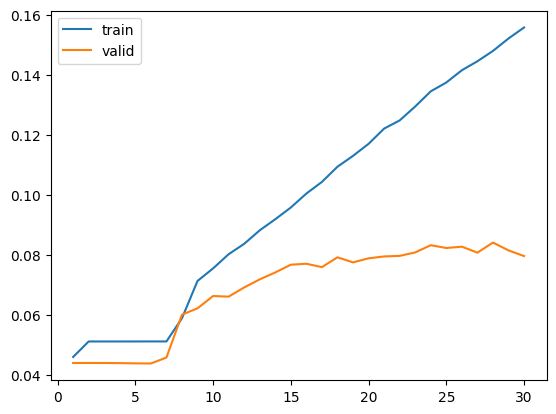

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [28]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
# import sys
# !{sys.executable} -m pip install gradio --quiet

In [ ]:
import gradio as gr

def model_response(human_text):

    print("Input: " + human_text)

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha

    print("Respuesta: " + human_text + ' ' + out_word)

    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

### 6 - Generación de secuencias nuevas

In [34]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [79]:
input_text='Estaba mirando que'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


'Estaba mirando que un poco la'

### 7 - Beam search y muestreo aleatorio

In [80]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [81]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if (temp == 1):
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  else:
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0] 

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp) 

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update)) 

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp) 

    return history_tokens

In [131]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=3,input="me dijo que", temp=1)

1/1 [==============================] - 0s 21ms/step


In [132]:
# veamos las salidas
for salida in salidas:
  print(decode(salida))


['me dijo que no no no']
['me dijo que no no como']
['me dijo que no no pero']
['me dijo que no no su']
['me dijo que no pero no']
['me dijo que no pero un']
['me dijo que no no lo']
['me dijo que un puesto']
['me dijo que no había fuera']
['me dijo que un lentamente la']


### 8 - Conclusiones
Se entrenó un modelo con frgmentos de textos de Borges, Cortazar y Bioy Casares, generando secuencias de 3 palabras para predecir la 4ta. 
El modelo, si bien se intentó entrenarlo con distintos hiper-parametros, no logró un accuracy mayor que el 0.1 en validacion, y llega un punto que empieza a haber mucho overfitting.
Con este ultimo modelo entrenado, se pudieron predecir algunas palabras que tienen sentido, como:

```python
INPUT = 'Estaba mirando que'
OUTPUT = 'Estaba mirando que un poco la'
```

O al buscar con Beam Search pudimos obtener algo como esto:

```python
INPUT = 'me dijo que'
OUTPUTS = 
['me dijo que no no no']
['me dijo que no no como']
['me dijo que no no pero']
['me dijo que no no su']
['me dijo que no pero no']
['me dijo que no pero un']
['me dijo que no no lo']
['me dijo que un puesto']
['me dijo que no había fuera']
['me dijo que un lentamente la']
```
Algunas de las palabras generadas tienen relacion con las anteriores, aunque suele generar muchas palabras cortas, que normalmente son conectores, pronombres, preposiciones o conjunciones, que supongo que serán mas probables porque aparecen mas veces en el texto.
